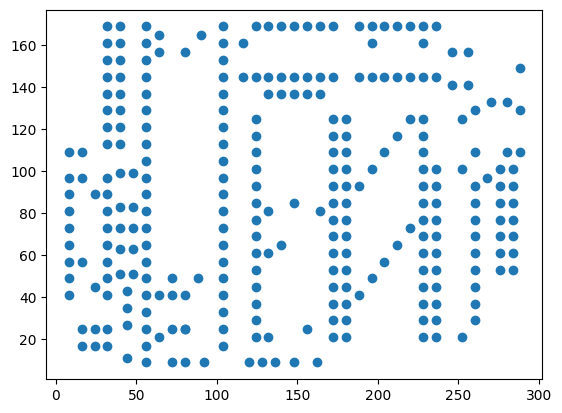

In [24]:
# Reading file

import numpy as np
import matplotlib.pyplot as plt

class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

#file_name = "eil51.tsp.txt"
file_name = "a280.tsp.txt"
#file_name = "pcb442.tsp.txt"

intro_lines = 6        # MAKE THEM CONSTANT
cities_amount = 280     # MAKE THEM CONSTANT

cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.scatter(coordinates_x, coordinates_y)

Init Path
True
34434.84526951124


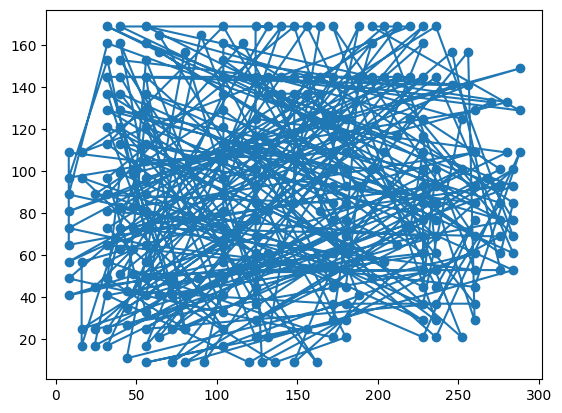

Gready Path
True
8356.2688662323


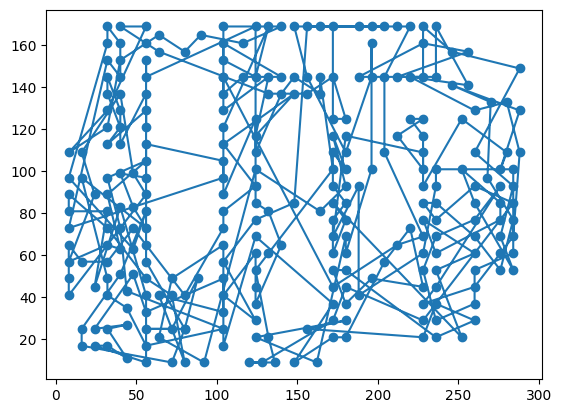

C:\Users\pmchrist\AppData\Local\Temp\ipykernel_13728\1331577433.py:156: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):


Simulated Annealing Solution
True
3656.653174408125


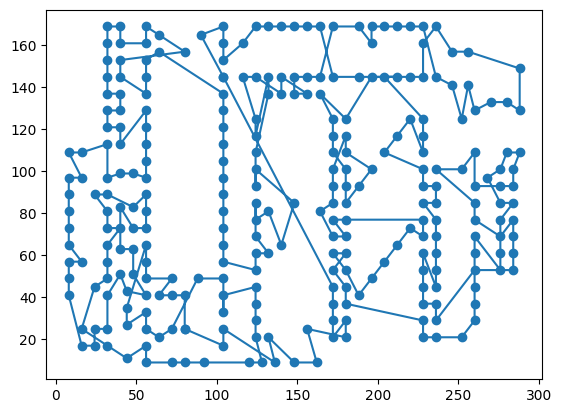

Worse Solutions accepted:  25362


In [34]:
import copy

class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)

    # Finds overall size of the path (Fitness Function)
    # Euclidean distance
    def eval_distance(self):
        distance = 0
        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )
        return distance

    # Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

    # Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.scatter(coordinates_x, coordinates_y)
        plt.plot(coordinates_x, coordinates_y)
        plt.show()
    # Print Path
    def visualize_print(self):
        print(self.city_ids)

    # Generating new paths
    # Random Permutations, k=amount of swaps
    def generate_new_path_random_swapping(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
    # Inserting of vertices, k=amount of inserts
    # Take a vertex, place it in a location, shift other
    def generate_new_path_insertting(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            # Saving Value
            insert_value = city_ids_new[ids_to_swap[j+1]]
            # Shifting
            city_ids_new[ids_to_swap[j]+1:ids_to_swap[j+1]+1] = city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] 
            # Inserting
            city_ids_new[ids_to_swap[j]] = insert_value
        return Path(city_ids_new)
    # k-Opt
    def generate_new_path_k_opt(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(k-1):
            city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] = reversed(city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]])
        return Path(city_ids_new)
                

# Generating an initial guess for the Path (Simplest way to create initial guess is just to shuffle)
import random
random.seed(42)
shuffled = sorted(cities, key=lambda k: random.random())
shuffled.append(shuffled[0])    # So that path is cycle
city_ids_init_path = []
for city in shuffled:
    city_ids_init_path.append(city.id)
initial_path = Path(city_ids_init_path)
print("Init Path")
print(initial_path.eval_validity())     # If everything is ok it should be True
print(initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it


# Iterative Method (Greedy) to find the solution
iterative = True
if iterative:
    # Random Permutations to find the better path
    path = initial_path
    for i in range(200_000):
        #new_path = path.generate_new_path_random_swapping(k=1) # k = Amount of swaps
        #new_path = path.generate_new_path_insertting(k=1)      # k = Amount of inserts
        new_path = path.generate_new_path_k_opt(k=5)           # k = amount of rewires
        if new_path.eval_distance() < path.eval_distance():
            path = new_path
    print("Gready Path")
    print(path.eval_validity())     # If everything is ok it should be True
    print(path.eval_distance())     # Evaluate circuit size
    path.visualize()                # And see it


# Simulated Annealing

best_path = initial_path
current_path = initial_path
current_energy = initial_path.eval_distance()

step = 0
step_max = 200_000

# Cooling Schedules
# http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/

temp_max = initial_path.eval_distance()/cities_amount   # Average path in initial solution
temp_min = 0
temp_current = temp_max

def cool_lin_a():
    return temp_min + (temp_max - temp_min) * ((step_max - step)/step_max)  # linear additive cooling
def cool_quad_a():
    return temp_min + (temp_max - temp_min) * ((step_max - step)/step_max)**2   # quadratic additive cooling
def cool_lin_m():
    return temp_max /  (1 + alpha * step)           # linear multiplicative cooling
def cool_quad_m():
    return temp_min / (1 + alpha * step**2)         # quadratic multiplicative cooling
def cool_exp_m():
    return temp_max * alpha**step                   # exponential multiplicative cooling
def cool_log_m():
    return temp_max / (alpha * np.log(step + 1))    # logarithmical multiplicative cooling

worse_sol = 0
# Annealing Schedule
while step < step_max:
    
    step += 1

    # Get candidate solution
    #candidate_path = current_path.generate_new_path_random_swapping(k=1) # k = Amount of swaps
    #candidate_path = current_path.generate_new_path_insertting(k=1)      # k = Amount of inserts
    candidate_path = current_path.generate_new_path_k_opt(k=2)           # k = amount of rewires

    candidate_energy = candidate_path.eval_distance()
    delta_energy = candidate_energy - current_energy    # Positive if solution is better, and is always accepted
    if delta_energy < 0:
        best_path = candidate_path

    if np.random.random() < np.exp(-delta_energy / temp_current):
        if delta_energy > 0:
            worse_sol += 1
        current_energy = candidate_energy
        current_path = candidate_path
    
    # Cooling Function
    alpha = 0.8
    temp_current = cool_quad_a()


# generate some final stats
print("Simulated Annealing Solution")
print(best_path.eval_validity())     # If everything is ok it should be True
print(best_path.eval_distance())     # Evaluate circuit size
best_path.visualize()                # And see it
print("Worse Solutions accepted: ", worse_sol)


# Future Discussions and further optimizations

 PreCalculate Distance between all cities and use lookup table